### Name: David Ryan
### StudentID: 0867284

# Lab 4: Comparison of Binary Classifiers

## TODO rewrite

Dataset: https://archive.ics.uci.edu/ml/datasets/seeds

In this exercise we use a breast cancer dataset (see https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). All columns in this dataset are numerical except the column `diagnosis` which is ordinal. Each example is a breast cancer case with diagnosis either M (malignant) or B (benign).

We will train a binary classification model to predict the diagnosis. We assume that misclassifying diagnosis M as B is more costly than misclassifying B as M, as cases classified as M can be further tested, while malignant cases misclassified as B may remain unnoticed. In other words, we would like to train a model that has high recall for class M, while the precision of the model for class M is not that important.

The `diagnosis` column is the *dependent variable* or *target* for classification, while all other columns are the *predictors*. We will use the common convention to refer to the predictors as **X** and to the target as **y**.  

In the process of training the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of two alternative classifiers: SVM and Random Forest.

Note that any data preparation of the predictors needs to be applied separately to each of these sets.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
colors = np.array(['orange', 'blue', 'lime', 'red', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## EDA - Exploratory Data Analysis

In [3]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [4]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [5]:
df.describe()

area   perimeter  compactness  length of kernel  width of kernel  \
count  210.000000  210.000000   210.000000        210.000000       210.000000   
mean    14.847524   14.559286     0.870999          5.628533         3.258605   
std      2.909699    1.305959     0.023629          0.443063         0.377714   
min     10.590000   12.410000     0.808100          4.899000         2.630000   
25%     12.270000   13.450000     0.856900          5.262250         2.944000   
50%     14.355000   14.320000     0.873450          5.523500         3.237000   
75%     17.305000   15.715000     0.887775          5.979750         3.561750   
max     21.180000   17.250000     0.918300          6.675000         4.033000   

       asymmetry coefficient  length of kernel groove        type  
count             210.000000               210.000000  210.000000  
mean                3.700201                 5.408071    2.000000  
std                 1.503557                 0.491480    0.818448  
min                 0.765100                 4.519000    1.000000  
25%                 2.561500                 5.045000    1.000000  
50%                 3.599000                 5.223000    2.000000  
75%                 4.768750                 5.877000    3.000000  
max                 8.456000                 6.550000    3.000000

In [6]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

First of all let's check for missing values and outliers.

In [7]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Let's check the boxplots of the numerical columns for outliers.

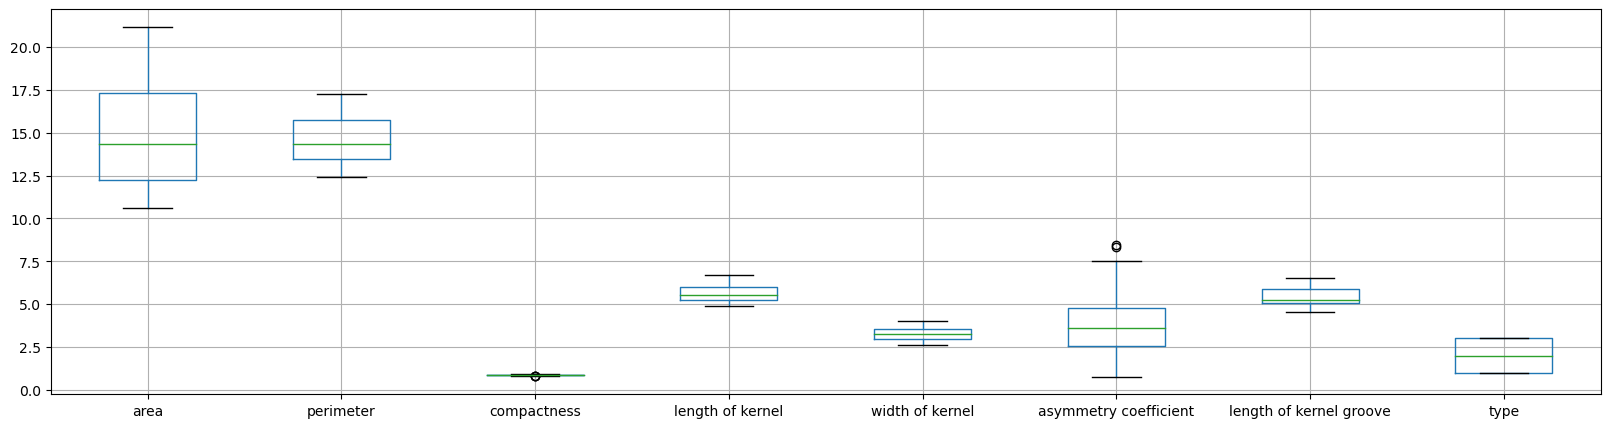

In [8]:
df.boxplot(figsize=(20,5))
plt.show()

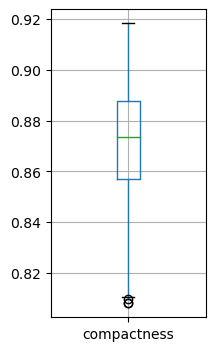

In [9]:
df[['compactness']].boxplot(figsize=(2,4))
plt.show()

The only fields with outliers are `compactness` and `asymmetry coefficient`. We will apply log transformation followed by `RobustScaler` to them. To all other predictor columns we will apply `StandardScaler`.  

In [10]:
names_all = [c for c in df if c not in ['type']]
names_outliers = ['compactness', 'asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

# Formulating a binary classification problem

The seeds dataset is split into three different group; Kama, Rosa and Canadian seeds. This poses a problem as we need to somehow formulate this as a binary classification problem.

The best way I can think of approaching this is to select one seed type as our target, and reformulate the problem as trying to predict whether a sample is or is not this particular type of seed. In order to minimize the amount of misclassifications, we'll try to determine the seed that is most dissimilar to the other two.

We'll apply the clustering techniques learned from the previous E-tivity to see if we can isolate one type of seed to its own cluster, with the other two in the other cluster.

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [12]:
# We'll need to do some data preparation for the clustering, so deep copy
# the dataset so we don't pollute the original data
df_clustering = copy.deepcopy(df)
df_clustering.drop('type', axis=1)

# Clustering algorithms can be sensitive to outliers and differing scales,
# so we'll scale our temporary dataset now 
robust_scaler = RobustScaler()
df_clustering[names_outliers] = np.log(df_clustering[names_outliers])
df_clustering[names_outliers] = robust_scaler.fit_transform(df_clustering[names_outliers])

standard_scaler = StandardScaler()
df_clustering[names_no_outliers] = robust_scaler.fit_transform(df_clustering[names_no_outliers])

AgglomerativeClustering worked well for me in the previous E-tivity, so we'll use that here as well

In [13]:
from sklearn.decomposition import PCA

ac = AgglomerativeClustering(n_clusters=2).fit_predict(df_clustering)

In [14]:
pca = PCA(n_components=2).fit_transform(df_clustering)

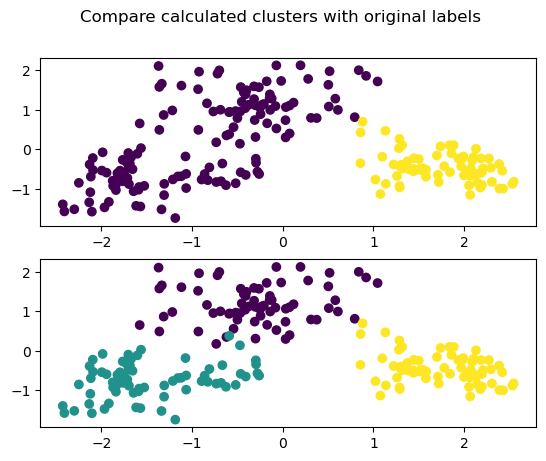

In [15]:
fig, axs = plt.subplots(2)
fig.suptitle('Compare calculated clusters with original labels')
axs[0].scatter(pca[:,0], pca[:,1], c=ac)
axs[1].scatter(pca[:,0], pca[:,1], c=df['type'], label=df['type'].unique())
plt.show()

We can see very clear correlation between the original labels and the detected clusters. Lets see exactly how accurate the clustering was.

In [16]:
df_clustering['cluster'] = pd.Series(ac, index=df_clustering.index)
df_clustering.groupby('cluster')['type'].value_counts()

cluster  type
0        1       70
         2       70
1        3       70
Name: type, dtype: int64

We can see that 100% of samples with the `type==3` has been assigned to cluster `1`. Thus, we will select `3` as the positive target of our classification.

## Data Preparation

First, will drop the type field and replace it with our formulated feature.

In [17]:
mapper = {1: 0, 2: 0, 3: 1}
df['is_canadian'] = df['type'].replace(mapper)
df = df.drop('type', axis=1)
df['is_canadian'].value_counts()

0    140
1     70
Name: is_canadian, dtype: int64

## This is as far as I've got so far

We will attempt training SVM and Random Forest classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of his pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns. 

In [18]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [19]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with `FeatureUnion`. 

In [20]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [21]:
y = df['is_3']
X = df.drop('is_3', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

KeyError: 'is_3'

The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [ ]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

The parameter `refit=True` makes the GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

Let's repeat the same experiment but with the Random Forest classifier.

In [ ]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [ ]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [ ]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [ ]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

We will use a pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

In [ ]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both classifiers perform well with SVM being slightly better. Most important, both have high recall for class 1, which is what we were looking for. We can pick SVM to train a final model on the whole dataset. These results will vary slightly when you run this notebook again. Ideally, the code could be enhanced to run the entire experiment multiple times and average the results.

We can also examine the ROC curves of the two classifiers for class 1.

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that both classifiers perform significantly better than a random guess (the red dashed line). 

# Task 3: Train a third classifier

For this task, I will choose a Multi-Layer Perceptron (MLP) Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier(max_iter=1000))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],  
    'mlp__solver': ['lbfgs', 'sgd', 'adam'], 
    'mlp__alpha': np.logspace(-1, 1, 5),
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

In [ ]:
clf = MLPClassifier(max_iter=500).fit(X_train, y_train)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

In [ ]:
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='MLP (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Print the actual values
columns = ["accuracy", "precision", "recall", "f1_score"]
metrics = pd.DataFrame(np.vstack([SVM_metrics, RF_metrics, MLP_metrics]), columns=columns)
metrics.insert(0, 'model', ["SVM", "RF", "MLP"])
metrics

## Train a Final Model

Finally, we can train an MLP model with all data we have, assuming that the more data we have the better the model.

In [ ]:
# function to remove the string 'mlp__' from the names of the parameters in MLP_best_params
def transform(dict):
    return {key.replace('mlp__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, MLPClassifier(**transform(MLP_best_params)))

final_model = pipe.fit(X, y)

We can also store this model on disk.

In [ ]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))